<div>
<img src="https://notebooks.dtcglaciers.org/_images/ESA_logo.svg" width="160" align='right'/>
</div>

# Validating DTC-Glaciers EO-DT-Enhanced Data cubes (L2)

To assess the performance of different **L2 data cubes**, this notebook illustrates the capabilities of the **DTC Glaciers validation framework**.  
The objective is to evaluate L2 data cubes by comparing their model-derived estimates against independent observations available from the corresponding **L1 data cubes**.

This validation step is a core component of the DTC Glaciers concept, providing a transparent way to quantify consistency between observations and model-based reconstructions, and to characterise associated uncertainties.

We begin by opening two examples from the pre-processed **L2 data cubes**:

If required, install the DTCG API using the following command:

```
!pip install 'dtcg[jupyter] @ git+https://github.com/DTC-Glaciers/dtcg'
```

Run this command in a notebook cell.

In [1]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt

from dtcg import DEFAULT_L2_DATACUBE_URL

In [2]:
rgi_id_ice = "RGI60-06.00377"  # Brúarjökull
rgi_id_aut = "RGI60-11.00719"  # Vernagtferner

def get_l2_data_tree(rgi_id):
    return xr.open_datatree(
            f"{DEFAULT_L2_DATACUBE_URL}{rgi_id}.zarr",
            chunks={},
            engine="zarr",
            consolidated=True,
            decode_cf=True,
        )

data_tree_ice = get_l2_data_tree(rgi_id_ice)
data_tree_aut = get_l2_data_tree(rgi_id_aut)

## Validation of DTC-Glaciers output

The **validation** within DTC-Glaciers consists of a combination of **in-situ observations** and **Earth observation (EO) data** from the **L1 data cubes**. The entire validation framework is built around the `DatacubeValidator`, which only requires a **data tree** as input:

In [3]:
from dtcg.validation.validator import DatacubeValidator

validator_ice = DatacubeValidator(data_tree_ice)
validator_aut = DatacubeValidator(data_tree_aut)

We assess the performance of different **L2 data cubes** with respect to observations by calculating the following metrics:

In [4]:
validator_ice.get_description_of_metrics()

{'MeanAbsD': 'Mean Absolute Deviation',
 'MeanD': 'Mean Deviation',
 'MedianD': 'Median Deviation',
 'RMSD': 'Root Mean Squared Deviation',
 'CORRCOEF': 'Pearson correlation coefficient'}

To account for **observation** and **model uncertainty** during validation, we rely on **[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))**. For this purpose, the **performance metrics** are not only evaluated for the **most likely** observation and model values, but we also generate a **distribution** for each metric.

This is done by repeatedly **resampling the time series** in coherent multi-year blocks and **drawing** a plausible value for each resampled year from the corresponding **uncertainty description**. For **observations**, we assume a **normal distribution**, while the **model output** is represented by **seven quantiles** (0.05, 0.15, 0.25, 0.5, 0.75, 0.85, and 0.95).

By default, this procedure is **repeated 5,000 times**. The resulting sampling distribution is then summarised using a **90% confidence interval**, which is shown in brackets in the validation output below.

Below, we show two examples of the validation framework for our two case study regions, which differ in their **data availability**.

## Iceland

In Iceland, we have **Earth observation data** from **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** (CryoSat-2), as well as **in-situ observations** from **[WGMS](https://wgms.ch/)** for some glaciers.

Let’s see which **L2 data cubes** are available:

In [5]:
list(data_tree_ice.keys())

['L1',
 'L2_Daily_Cryosat_2011_2020',
 'L2_Daily_Hugonnet_2000_2020',
 'L2_Daily_Hugonnet_2010_2020',
 'L2_SfcDaily_Cryosat_2011_2020']

For the following analysis, we selected the **daily mass balance model** calibrated with **[CryoTEMPO-EOLIS](https://cryotempo-eolis.org/)** (CryoSat-2) for the period **2011–2020**. We then compared it to the same model calibrated with **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** for the period **2010–2020**.

In [6]:
l2_list_ice = ['L2_Daily_Cryosat_2011_2020', 'L2_Daily_Hugonnet_2010_2020']

With the `DatacubeValidator` already set up, we only need to provide the **L2 data cubes** of interest. The validator then checks which reference data are available in the **L1 data cubes** and computes the corresponding **performance metrics**.

In [7]:
validation_data_ice, bootstrap_args_ice = validator_ice.get_validation_for_layers(
    l2_name_list=l2_list_ice, return_bootstrap_args=True)

Let’s start by examining the results of comparing the **L2 data cubes** with the **CryoSat-2 observations**:

In [8]:
validation_data_ice['CryoSat2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 CryoSat2 elevation change 2011-01-01_2025-09-01,,,,,
L2_Daily_Cryosat_2011_2020,"0.6 (0.5, 0.8)","-0.0 (-0.3, 0.2)","-0.0 (-0.4, 0.3)","0.7 (0.7, 0.9)","0.88 (0.71, 0.89)"
L2_Daily_Hugonnet_2010_2020,"2.9 (2.1, 3.6)","-2.9 (-3.6, -2.0)","-3.6 (-3.7, -1.3)","3.4 (2.8, 4.1)","0.83 (0.58, 0.82)"


We see that the data cube calibrated with **CryoSat-2** outperforms the one calibrated with **Hugonnet et al. (2021)**.  
The metrics that quantify **absolute differences** (`MeanAbsD`, `RMSD`) show smaller values, indicating a better overall agreement.

Metrics that quantify **bias** (`MeanD` and `MedianD`) are closer to zero, and their **confidence intervals span both positive and negative values**, suggesting no strong systematic bias. Finally, the **correlation coefficient** is higher, indicating a stronger linear relationship between the observations and the model output.

To help with interpretation, we can also take a look at the **bootstrap settings** used during the validation:

In [9]:
bootstrap_args_ice['CryoSat2']

{'ci_level': 0.9, 'n': 177, 'n_boot': 5000, 'block_length': 13, 'seed': 0}

We see that the reported metric intervals correspond to a **90% confidence interval** (`ci_level`). In total, **173 observations** are available (`n`). The validation is based on **5,000 bootstrap resamplings** of the time series and repeated evaluations of the metrics (`n_boot`). A **block length of 13 observations** was used to preserve temporal coherence (`block_length`). For **reproducibility**, a fixed random `seed` is applied.

However, it is important to note that this validation is **not fully independent**, because the CryoSat-2 data cube uses part of the same data for calibration. Therefore, we also evaluate the model performance using **independent data only** by defining a dedicated **validation period**:

In [10]:
validation_cryosat_2020_2025 = validator_ice.get_validation_for_layers(
    l2_name_list=l2_list_ice,
    baseline_date='2020-01-01',  # the date where the cumulated elevation change starts
    obs_list=['CryoSat2'],  # we can select to only perform the validation on one observation
    validation_period='2020-01-01_2025-12-31',)  # define the period which should be considered

validation_cryosat_2020_2025['CryoSat2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 CryoSat2 elevation change 2020-01-01_2025-09-01,,,,,
L2_Daily_Cryosat_2011_2020,"0.6 (0.5, 0.7)","0.4 (0.2, 0.6)","0.4 (0.2, 0.6)","0.7 (0.6, 0.9)","0.93 (0.78, 0.91)"
L2_Daily_Hugonnet_2010_2020,"0.8 (0.6, 1.2)","-0.7 (-1.1, -0.4)","-0.6 (-1.0, -0.3)","1.0 (0.8, 1.5)","0.89 (0.66, 0.87)"


Even when using the **independent validation period**, the **CryoSat-2–calibrated data cube** still outperforms the **Hugonnet-calibrated data cube**. However, the differences are **less pronounced** than when using the full time period.

We can also use the `DatacubeValidator` to gain a **visual impression of model performance** by creating **comparison plots**.

First, for the **entire period**:

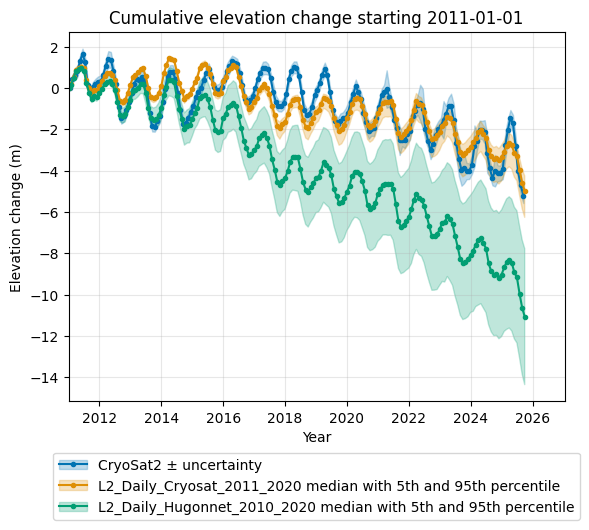

In [11]:
validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='CryoSat2')
plt.show()

Or for the **independent validation period**, by defining a `baseline_date`:

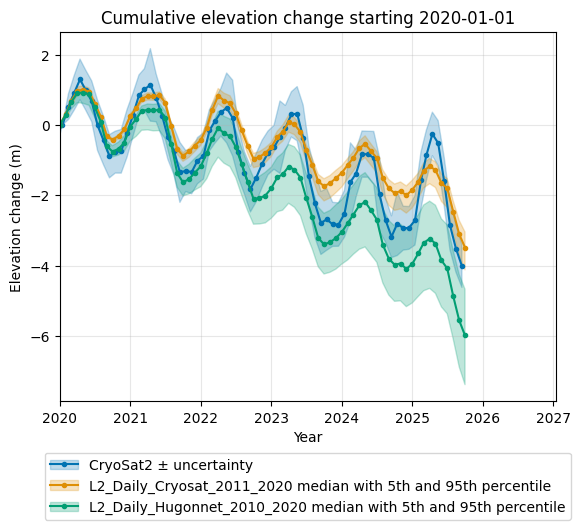

In [12]:
fig = validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='CryoSat2',
                                                   baseline_date='2020-01-01')
plt.show()

Another available data source for our test glacier is **in-situ mass balance observations** from **[WGMS](https://wgms.ch/)**:

In [13]:
validation_data_ice['WGMS']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
L1 WGMS annual mass balance 2000-2024,,,,,
L2_Daily_Cryosat_2011_2020,"415.9 (346.9, 501.2)","9.7 (-138.7, 187.5)","3.0 (-131.5, 169.7)","530.2 (440.1, 630.6)","0.49 (0.28, 0.72)"
L2_Daily_Hugonnet_2010_2020,"513.2 (373.5, 637.9)","-294.6 (-445.3, -110.7)","-308.1 (-476.3, -121.3)","621.2 (477.0, 754.4)","0.48 (0.24, 0.70)"


In [14]:
bootstrap_args_ice['WGMS']

{'ci_level': 0.9, 'n': 25, 'n_boot': 5000, 'block_length': 5, 'seed': 0}

For this dataset as well, the **CryoSat-2–calibrated data cube** outperforms the **Hugonnet-calibrated data cube** for most metrics. This highlights the **added value of Earth observation data**, confirmed through validation against **independent in-situ measurements**.

Visualisations are also available for the **in-situ data**:

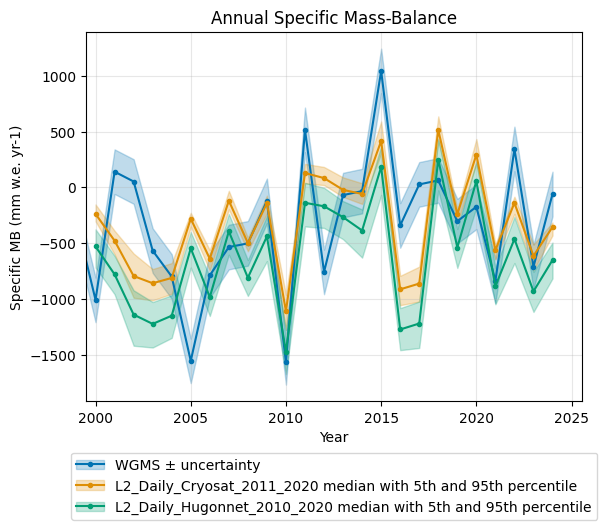

In [15]:
validator_ice.get_validation_plot_for_layers(l2_name_list=l2_list_ice, obs_name='WGMS')
plt.show()

## Austria

In Austria, we have **EO data** from **[ENVEO](https://www.enveo.at/)** (Sentinel-2), as well as **in-situ observations** from **WGMS** for some glaciers. See [this notebook](01_L1_datacubes.ipynb) for further explanations of the available data.

Let’s see which **L2 data cubes** are available:

In [16]:
list(data_tree_aut.keys())

['L1',
 'L2_Daily_Hugonnet_2000_2020',
 'L2_Daily_Hugonnet_2010_2020',
 'L2_SfcDaily_Hugonnet_2000_2020',
 'L2_SfcDaily_Hugonnet_2010_2020']

In this case, we compare the impact of **two different mass balance models** that both use the same calibration data from **[Hugonnet et al. (2021)](https://doi.org/10.1038/s41586-021-03436-z)** over the period **2010–2020**.

The first model is a **daily temperature-index model**, which is equivalent to the **OGGM v1.6.2 default approach**, but implemented at **daily resolution**. The second model is a **temperature-index model enhanced with a bucket-based snow-tracking scheme**. This model follows the approach described in **[Schuster et al. (2023)](https://doi.org/10.1017/aog.2023.57)** and in the **[OGGM mass-balance sandbox](https://github.com/OGGM/massbalance-sandbox)**.

In [17]:
l2_list_aut = ['L2_Daily_Hugonnet_2000_2020', 'L2_SfcDaily_Hugonnet_2000_2020']

validation_data_aut, bootstrap_args_aut = validator_aut.get_validation_for_layers(
    l2_name_list=l2_list_aut, return_bootstrap_args=True)

Not all data available for Sentinel2


You may see a warning message indicating that some data cubes are missing data for the validation. This happens because validation with **Sentinel-2 data** requires a **modelled snowline**, which is only available when using the newly implemented **snow-tracking bucket system**.

We will return to this point later. For now, we first look at the **WGMS-based validation**:

In [18]:
validation_data_aut['WGMS']

,MeanAbsD (mm w.e. yr-1),MeanD (mm w.e. yr-1),MedianD (mm w.e. yr-1),RMSD (mm w.e. yr-1),CORRCOEF
L1 WGMS annual mass balance 2000-2024,,,,,
L2_Daily_Hugonnet_2000_2020,"290.4 (242.8, 371.1)","-28.5 (-182.9, 15.6)","-116.1 (-233.8, -0.1)","353.0 (305.5, 452.0)","0.87 (0.67, 0.91)"
L2_SfcDaily_Hugonnet_2000_2020,"336.8 (287.8, 436.8)","-77.8 (-246.1, -15.1)","-91.5 (-248.3, 41.6)","431.5 (365.5, 543.6)","0.89 (0.73, 0.93)"


In [19]:
bootstrap_args_aut['WGMS']

{'ci_level': 0.9, 'n': 25, 'n_boot': 5000, 'block_length': 5, 'seed': 0}

The comparison of the two options shows **slightly better performance** for the **daily model without snow tracking**.

Let’s visualise the data:

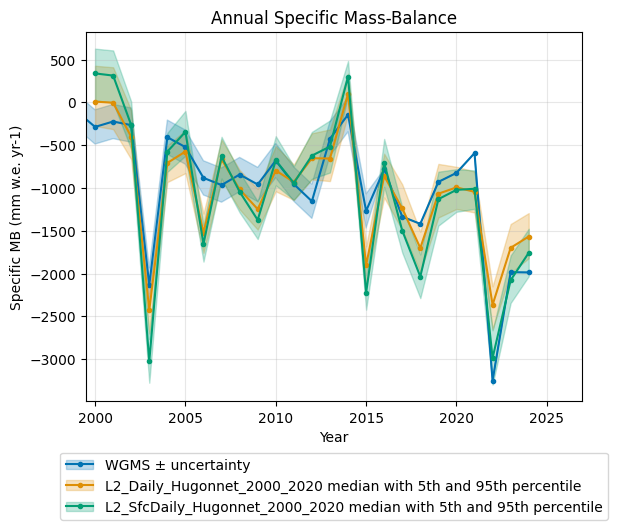

In [20]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='WGMS')
plt.show()

For the **surface-tracking model**, we see that the **extreme year 2022** is captured much better. This improvement is likely related to the **bucket-based snow-tracking system**, which implicitly includes **albedo feedbacks**. In 2022, the glacier surface became snow-free very early, leading to a **darker surface** and therefore **enhanced ablation**.

However, the newly developed **bucket system** still requires further research and development before it can be considered operational.

A promising future direction is the **assimilation of snowline observations**. By including surface tracking, we are able to make use of this new type of **EO data**, in particular **snowline altitudes derived from Sentinel-2**. In the current implementation, these data are used **only for validation**, but future developments should make it possible to also include them directly in the **assimilation pipeline**.

The validation metrics of this first implementation are shown below:

In [21]:
validation_data_aut['Sentinel2']

,MeanAbsD (m),MeanD (m),MedianD (m),RMSD (m),CORRCOEF
L1 Sentinel2 snowline 2015-07-04_2021-09-25,,,,,
L2_SfcDaily_Hugonnet_2000_2020,"109.1 (92.7, 133.0)","9.9 (-38.7, 53.6)","15.5 (-0.2, 15.5)","167.3 (138.8, 205.1)","0.80 (0.72, 0.87)"


The modelled snowline evolution can also be **visualised** together with the observations:

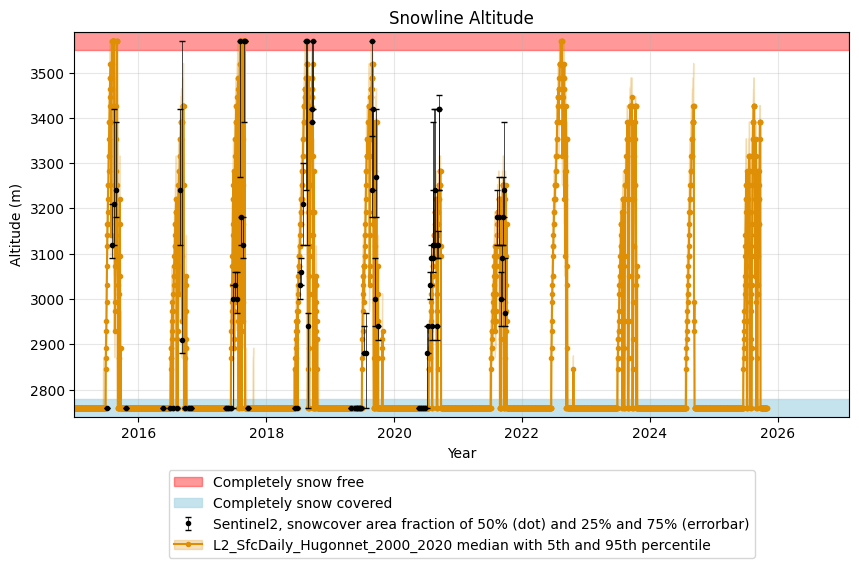

In [22]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='Sentinel2',)
plt.show()

The plot is quite dense when shown over the full period. Therefore, you can use `x_lim` to zoom in on a specific period of interest:

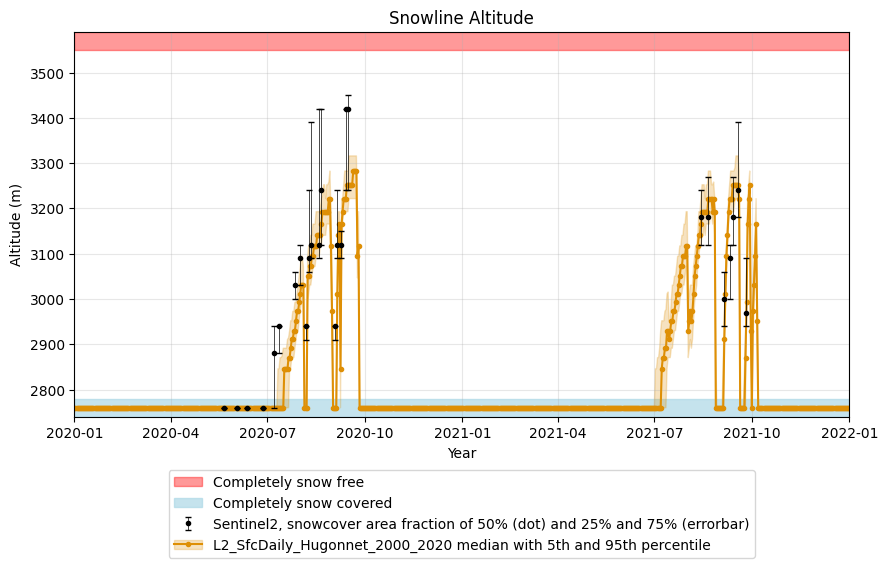

In [23]:
validator_aut.get_validation_plot_for_layers(l2_name_list=l2_list_aut, obs_name='Sentinel2',
                                             x_lim=[2020, 2022])
plt.show()